<font size="5">__multi-class classification model for product category prediction: Models deployment__

In [8]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_curve,auc
from warnings import simplefilter
from matplotlib.pylab import plt
%matplotlib inline

In [9]:
#importing the data file created in the "data manipulation" section:
data = pd.read_csv("final_manipulated_data_ready_for_models.csv",low_memory=False) #code based file

In [10]:
# removing columns which are unnecessary for the model:

#   code based file
data.drop(columns=['cat+custno+date,ordno,orderdate,prodcat1','Unnamed: 0','index', 'ordno','orderdate', 'dt_min','dt_max','cat+custno+date','custno'],inplace=True)  #code based file
data=data.astype('float64')

#replacing the NaNs with zeros:
data.fillna(0,inplace=True)

<font size="3">The data is highly imbalanced, as 98% of the rows are classified has zero (didn't purchase) which may cause a almost "always-say-0" situation in which the model will almost always predict 0. in order to create a more balanced data I will randomly extract some of the data rows classified as 0.
I will leave a number of zero classified rows that will be equal to 50% of the data, in order for the classifier to still be more dominant than the other categories

In [11]:
#exploring the distribution of the values in the 'prodcat1' column:
print(data['prodcat1'].value_counts())
print(data['prodcat1'].value_counts(normalize=True))

0.0    746416
3.0      5833
2.0      1315
1.0       460
Name: prodcat1, dtype: int64
0.0    0.989910
3.0    0.007736
2.0    0.001744
1.0    0.000610
Name: prodcat1, dtype: float64


In [12]:
# removing random prodcat1 zero lines to balance the data:
num_rows_to_sample=len(data[data['prodcat1']!=0])
data_sample_class_0=data[data['prodcat1']==0].sample(n=num_rows_to_sample, random_state=0)
data=data_sample_class_0.append(data[data['prodcat1']!=0])

#exploring the distribution of the values in the 'prodcat1' column after the sampling:
print(data['prodcat1'].value_counts())
print(data['prodcat1'].value_counts(normalize=True))
#note:the random state was added in order for the conclusions to match the results, if the code will run again.

0.0    7608
3.0    5833
2.0    1315
1.0     460
Name: prodcat1, dtype: int64
0.0    0.500000
3.0    0.383346
2.0    0.086422
1.0    0.030231
Name: prodcat1, dtype: float64


In [13]:
# creating the variables for the model and splitting to test and train samples:
X = data.drop(columns=['prodcat1'])
y = data.prodcat1

X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0)
#note:the random state was added in order for the conclusions to match the results, if the code will run again.

<font size="5">Training models

<font size="4">I'll compare the results of 3 models in order to choose the best one:<br>
- Decision tree
- Knearest neighbours
- SVM

desicion tree:
checking which max_depth will give the best results:

the best test accuracy reached is 0.62, with the minimum max_depth of 13


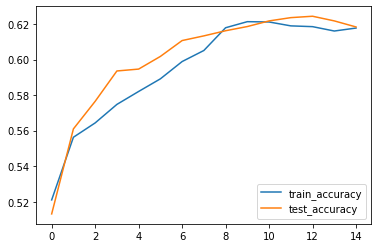

In [14]:
train_accuracy=[]
test_accuracy=[]
for i in range(1,16):
    clf = DecisionTreeClassifier(max_depth=i)
    clf.fit(X_train, y_train)
    avg_score_cv_train = np.mean(cross_val_score(clf, X_train, y_train, cv=10))
    avg_score_cv_test = np.mean(cross_val_score(clf, X_test, y_test, cv=10))
    train_accuracy.append(avg_score_cv_train)
    test_accuracy.append(avg_score_cv_test)

max_test_accuracy=max(test_accuracy)
best_max_depth=test_accuracy.index(max_test_accuracy)+1
print(f'the best test accuracy reached is {round(max_test_accuracy,2)}, with the minimum max_depth of {best_max_depth}')
plt.plot(train_accuracy, label="train_accuracy")
plt.plot(test_accuracy, label="test_accuracy")
plt.legend(loc='lower right')
plt.show()

Knearest neighbours:
checking which number of neighbours will give the best results

the best test accuracy reached is 0.57, with the minimum k_neighbors of 8


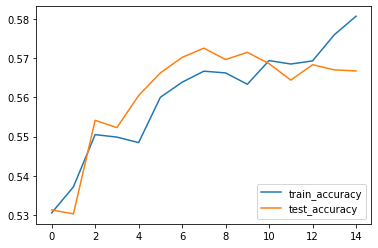

In [15]:
train_accuracy=[]
test_accuracy=[]
for i in range(1,16):
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(X_train, y_train)
    clf.predict(X_train)
    avg_score_cv_train = np.mean(cross_val_score(clf, X_train, y_train, cv=10))
    avg_score_cv_test = np.mean(cross_val_score(clf, X_test, y_test, cv=10))
    train_accuracy.append(avg_score_cv_train)
    test_accuracy.append(avg_score_cv_test)
    
max_test_accuracy=max(test_accuracy)
best_k_neighbors=test_accuracy.index(max_test_accuracy)+1
print(f'the best test accuracy reached is {round(max_test_accuracy,2)}, with the minimum k_neighbors of {best_k_neighbors}')
plt.plot(train_accuracy, label="train_accuracy")
plt.plot(test_accuracy, label="test_accuracy")
plt.legend(loc='lower right')
plt.show()

the Decision Tree result is better than the Knearest neighbours result

<font size="3">Comparing the Decision Tree to SVM:

In [16]:
# ignore future warnings:
simplefilter(action='ignore', category=FutureWarning)
clf = SVC()
clf.fit(X_train, y_train)
avg_score_cv_train = np.mean(cross_val_score(clf, X_train, y_train, cv=10))
avg_score_cv_test = np.mean(cross_val_score(clf, X_test, y_test, cv=10))
train_accuracy.append(avg_score_cv_train)
test_accuracy.append(avg_score_cv_test)

print(f'the SVM test accuracy is {round(avg_score_cv_test,2)}')

the SVM test accuracy is 0.55


the Decision Tree result is also better than the SVM result.

<font size="3"> deploying ADAboosting model to improve the model accuracy:

In [17]:
clf = DecisionTreeClassifier(max_depth=best_max_depth)

In [ ]:
clf = AdaBoostClassifier(base_estimator=clf)
clf.fit(X_train, y_train)
avg_score_cv_train = np.mean(cross_val_score(clf, X_train, y_train, cv=10))
avg_score_cv_test = np.mean(cross_val_score(clf, X_test, y_test, cv=10))
print (f'DT ADA boosting classifier test accuracy is {round(avg_score_cv_test,2)}')


<font size="3"> the Adaboost didn't improve the results, as they are the same as the Decision Tree and K-nearest Neighbors results

<font size="5">__Summary__

<font size="3">Combining the Online activities data along with the orders data have enable the creation of a model with an<br> __63% accuracy in predicting If a customer will purchase a product and if so, from which category will he purchase it?__<br>

The work process was based on my following assumptions:<br> <br>
- Event1 and Event2 values are a result of the same activity, therefore the best way to use them is combined. <br>
  Their values are IDs  that are not equal to each other
(Event1:ID=1 is not equal to Event2:ID=1) <br>
- The data is incomplete as it is missing there are some order that do not have online data regarding them.<br> I didn't include these order rows in the final data. <br>
- There is no missing data in the order table- Some of the online activities didn't end with an order.<br> Those events where granted the order category 0. <br>
- The datetimes in both data files are both in the same time zone and are aligned and accurate. <br><br>
    
The prediction was based on the following explanatory variables: <br>
- __event1 and event2 values__: as was mentioned before, the best practice is to combined them as one. <br>
 the way I think will generate the best learning from them is to turn each combined value to a column as its value will be the number of times it occurred per "order" number of activities: total numbers of activities (event1 and 2 combination) each "order" generated. <br>
- __seconds diff between first and last activity__: the time which passed between the first activity and the last one per "order". <br>
- __Online category__: in case there was an actual order, the value will be the same as the order category. <br>
The variable is informative in cases were the online activity ended without an order. <br>


3 different models were deployed: Decision Tree, SVM and K-nearest Neighbors.
The Decision Tree generated the best results. <br>
To further improve the prediction quality an Ada-boosting model was deployed. <br>
The boosting caused no signinicant change in the results. <br>

__there is still a lot that can be done to improve this result (deploying Random Forest, other boosting technics, checking for optimal Parameters for the Ada Boost, etc.)__